(page:adsorbate_density)=
# (Integrated) Adsorbate Density Distribution

This script reads in an atomic configuration in the `.bgf` file format and calculates the (integrated) radial density distribution for a given elemental species in the configuration. In this specific case, we are counting the number of oxygen atoms in sphere segmets of 0.1 Å width radially outward from the geometric center of the structure. We can plot this value directly or we can integrate and normalize the bins based on the volume of the sphere segments, similar to the [oxidation state analysis](page:oxidation_state) before or the [radial distribution function analysis](page:rdf) later.

Here, we analyze the same strongly oxidized Pt / Pt-O core-shell nanoparticle used above for the [oxidation state analysis](page:oxidation_state). To start with, read in the data.

In [23]:
import pandas as pd

data = pd.read_csv("../data/data.csv")

Pick a structure to analyze. Choose a medium-oxidized structure with a metallic core but a strongly oxidized shell. Read in the structure into an `ase.Atoms` object.

In [24]:
from asetools.systemtools import read_bgf

sample = data.loc[(data["n_O"] == 400)].iloc[0]
atoms = read_bgf(sample["root"])

Visualize a cross-section of the structure by applying a cutting plane at the particle's center. Create a copy of the `ase.Atoms` object to avoid modifying the original.

In [25]:
from ase.visualize import view

viewatoms = atoms.copy()
center = viewatoms.cell.diagonal() / 2
viewatoms.translate((-1) * center)
viewatoms.translate([0,0,-38])

# Apply a cutting plane through the particle.
com = viewatoms.get_center_of_mass()
select = [viewatoms.index for viewatoms in viewatoms if viewatoms.position[2] < com[2] + 0.3]

view(viewatoms[select], viewer="x3d")

Analogous to what was discussed for the [oxidation state analysis](page:oxidation_state), the adsorbate density analysis evaluates the density radially outward from the particle's center. We therefore need to define a similar set of parameters as before: where the center of the particle is located, what the `probe` species is whose density will be evaluated, and what the `binwidth` is (*i.e.*, the increments of $r$ that define the sphere segments in which densities are calculated). The `binwidth` is then used to calculate number of bins, `nbins`, after establishing the largest distance-to-center in the system.

This procedure is very similar to what we implemented before for the [oxidation state analysis](page:oxidation_state). Hence, please refer to that page for more details.

In [26]:
import numpy as np

probe = "O"
binwidth = 0.1
center = np.sum(atoms.get_positions(), axis=0) / len(atoms)

Next, calculate the distance to the particle center for all `probe` atoms. We don't need the `neighborList` used before for the [oxidation state analysis](page:oxidation_state).

In [27]:
indices = [atom.index for atom in atoms if atom.symbol == probe]
dists = np.linalg.norm(atoms[indices].get_positions() - center, axis=1)

Next, we determine the maximum distance to the center, `dmax`, that occurs in the data set and calculate the number of integration bins, `nbins`, from this value in combination with `binwidth`.

In [28]:
dmax = max(dists)
nbins = int(dmax / binwidth)

Again we initialize empty lists which will hold results for the absolute (`bins`) and integrated (`intbins`) adsorbate densities.

In [29]:
bins = [0] * (nbins + 1)
intbins = [0] * (nbins + 1)

Loop through all `probe` atoms and determine which distance bin they fall into.

In [30]:
for d in dists:
    thisbin = int(d / binwidth)
    if thisbin <= nbins:
        bins[thisbin] += 1

To properly normalize the integrated density analysis with regards to the sphere segments, we require some additional data, for example the volume of the cell, `vol`, and the number of evaluated atoms, `ncnt`.

In [31]:
vol = atoms.get_volume()
ncnt = len(indices)

Now calculate the integrated density analysis by summing over `bins` and normalizing using the particle density `rho`. Here, we perform the spherical normalization as $4 \pi r^2 dr$ (where $dr$ in our case is `binwidth`) instead of $\frac{4}{3} \pi r^3$ because it is numerically faster to evaluate.

In [32]:
rho = ncnt / vol
norm = 4 * np.pi * rho * ncnt

for i, intbin in enumerate(intbins[:-1]):
    intbin = sum(bins[1:i+1])
    r = (i + 1) * binwidth
    intbin /= (norm * r * r * binwidth)
    intbins[i+1] = intbin

Visualize the results of the absolute and integrated adsorbate densities side-by-side.

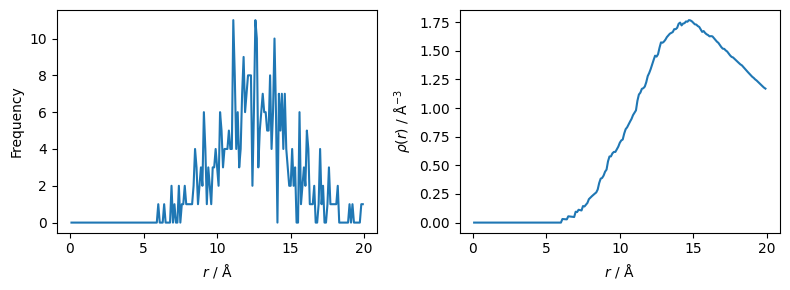

In [33]:
import matplotlib.pyplot as plt

x = []
yAbs = []
yInt = []
for i, cnt in enumerate(bins[1:]):
    x.append((i + 1) * binwidth)
    yAbs.append(cnt)
    yInt.append(intbins[i + 1])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3))
plt.rcParams.update({'font.size': 10})
ax1.plot(x, yAbs)
ax1.set_xlabel("$r$ / $\mathrm{\AA}$")
ax1.set_ylabel("Frequency")
ax2.plot(x, yInt)
ax2.set_xlabel("$r$ / $\mathrm{\AA}$")
ax2.set_ylabel("$\\rho(r)$ / $\mathrm{\AA}^{-3}$")
plt.tight_layout()
plt.show()